Load Data: https://www.kaggle.com/rmisra/news-category-dataset/code?datasetId=32526&searchQuery=df+%3D+pd.read_json%28file_path%2C+lines+%3D+True%29

Main Code: https://www.kaggle.com/hengzheng/news-category-classifier-val-acc-0-65

RUS/ROS: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

SMOTE: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import pandas as pd
def load_data(file_path):
    df = pd.read_json(file_path, lines = True)
    df['category'] = pd.Categorical(df['category'])
    df = df[df["short_description"] != ""]
    df['headlineDesc'] = df['headline']+ ' ' + df['short_description']
    return df[["headlineDesc", "category"]]

df = load_data('News_Category_Dataset_v2.json')
df.head()

,headlineDesc,category
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 5...,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT


In [ ]:
#different than original baseline (keras instead of spacy)
from keras.preprocessing.text import Tokenizer
# tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.headlineDesc)
X = tokenizer.texts_to_sequences(df.headlineDesc)
df['words'] = X
vocab_size = len(tokenizer.word_index) + 1
# delete some empty and short data
df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]
df.head()

,headlineDesc,category,words,word_length
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME,"[72, 100, 269, 1339, 2992, 6, 719, 133, 99, 25...",27
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT,"[42, 1642, 3030, 29315, 5, 27163, 5247, 8, 1, ...",20
2,Hugh Grant Marries For The First Time At Age 5...,ENTERTAINMENT,"[5897, 5371, 8449, 8, 1, 77, 54, 21, 420, 8450...",25
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT,"[2786, 14389, 3767, 62936, 2342, 13028, 5, 578...",26
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT,"[40141, 35327, 1541, 95, 45, 8344, 3148, 2, 94...",26


In [ ]:
from keras.preprocessing import sequence
import numpy as np
maxlen = 50
X = list(sequence.pad_sequences(df.words, maxlen=maxlen))
categories = df.groupby('category').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['category'].apply(lambda x: category_int[x])

word_index = tokenizer.word_index

EMBEDDING_DIM = 100

embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s unique tokens.' % len(word_index))
print('Total %s word vectors.' % len(embeddings_index))

Found 114348 unique tokens.
Total 400000 word vectors.


In [ ]:
from keras import layers
from keras.initializers import Constant
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

X = np.array(X)
Y = np_utils.to_categorical(list(df.c2id))

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X, Y = ros.fit_resample(X, Y)

In [ ]:
# split to training set and validation set
seed = 1234
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=seed)

In [ ]:
from keras.models import Sequential, Model
from keras.backend import clear_session
clear_session()

from tensorflow.keras import models
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
inp = layers.Input(shape=(maxlen,), dtype='int32')
embedding_layer = layers.Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

## embedding
x = embedding_layer(inp)
## apply attention
x = attention_layer(x, neurons=50)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=50, dropout=0.5, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=50, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(41, activation='softmax')(x)
## compile
model = models.Model(inp, y_out)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 100)      11434900    ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 100, 50)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 100, 50)      2550        ['permute[0][0]']                
                                                                                              

In [ ]:
history = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/30
13261/13261 [==============================] - 231s 17ms/step - loss: 2.3762 - accuracy: 0.3175 - val_loss: 1.9287 - val_accuracy: 0.4355
Epoch 2/30
13261/13261 [==============================] - 221s 17ms/step - loss: 1.9240 - accuracy: 0.4369 - val_loss: 1.7058 - val_accuracy: 0.4964
Epoch 3/30
13261/13261 [==============================] - 221s 17ms/step - loss: 1.7593 - accuracy: 0.4818 - val_loss: 1.5849 - val_accuracy: 0.5251
Epoch 4/30
13261/13261 [==============================] - 237s 18ms/step - loss: 1.6621 - accuracy: 0.5065 - val_loss: 1.5097 - val_accuracy: 0.5474
Epoch 5/30
13261/13261 [==============================] - 222s 17ms/step - loss: 1.5929 - accuracy: 0.5244 - val_loss: 1.4432 - val_accuracy: 0.5613
Epoch 6/30
13261/13261 [==============================] - 221s 17ms/step - loss: 1.5376 - accuracy: 0.5389 - val_loss: 1.3647 - val_accuracy: 0.5855
Epoch 7/30
13261/13261 [==============================] - 222s 17ms/step - loss: 1.4940 - accuracy: 0.5501

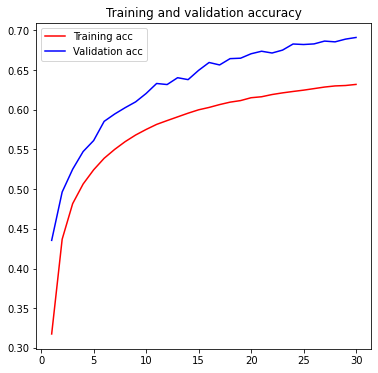

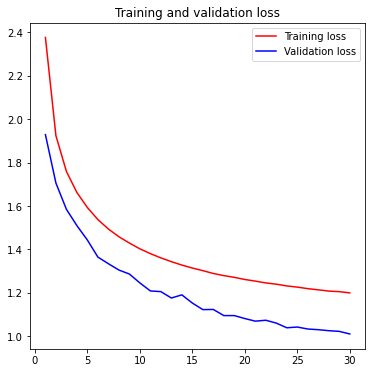

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

In [ ]:
# Final evaluation of the model
scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 69.12%


**SMOTE approach**

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=1)
X, Y = oversample.fit_resample(X,Y)

In [ ]:
# split to training set and validation set
seed = 1234
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=seed)

In [ ]:
from keras.models import Sequential, Model
from keras.backend import clear_session
clear_session()

from tensorflow.keras import models
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
inp = layers.Input(shape=(maxlen,), dtype='int32')
embedding_layer = layers.Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

## embedding
x = embedding_layer(inp)
## apply attention
x = attention_layer(x, neurons=50)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=50, dropout=0.5, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=50, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(41, activation='softmax')(x)
## compile
model = models.Model(inp, y_out)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 100)      11434900    ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 100, 50)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 100, 50)      2550        ['permute[0][0]']                
                                                                                              

In [ ]:
history = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/30
13261/13261 [==============================] - 233s 17ms/step - loss: 3.2926 - accuracy: 0.1157 - val_loss: 3.1840 - val_accuracy: 0.1419
Epoch 2/30
13261/13261 [==============================] - 224s 17ms/step - loss: 3.1642 - accuracy: 0.1461 - val_loss: 3.1022 - val_accuracy: 0.1584
Epoch 3/30
13261/13261 [==============================] - 221s 17ms/step - loss: 3.1066 - accuracy: 0.1581 - val_loss: 3.0688 - val_accuracy: 0.1660
Epoch 4/30
13261/13261 [==============================] - 220s 17ms/step - loss: 3.0680 - accuracy: 0.1675 - val_loss: 3.0215 - val_accuracy: 0.1788
Epoch 5/30
13261/13261 [==============================] - 221s 17ms/step - loss: 3.0405 - accuracy: 0.1738 - val_loss: 2.9962 - val_accuracy: 0.1847
Epoch 6/30
13261/13261 [==============================] - 222s 17ms/step - loss: 3.0190 - accuracy: 0.1789 - val_loss: 2.9784 - val_accuracy: 0.1883
Epoch 7/30
13261/13261 [==============================] - 224s 17ms/step - loss: 3.0031 - accuracy: 0.1827

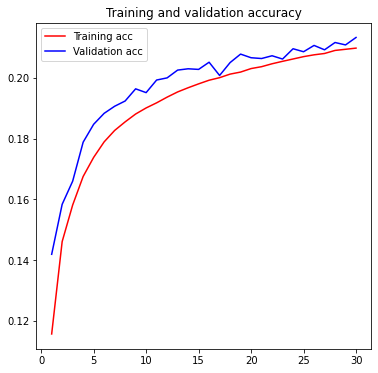

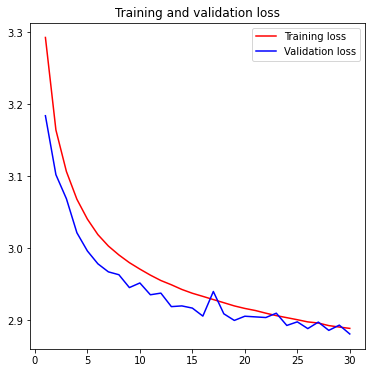

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

In [ ]:
# Final evaluation of the model
scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 21.33%
